# Introduction to hierarchical time series forecasting

## Setup

In [1]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
%config InlineBackend.figure_format = 'retina'

## Data

In [3]:
# load the data 
df = pd.read_csv("../data/tourism.csv") \
       .drop(columns=["Unnamed: 0"])

# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

df.head()

,quarter,region,state,trips,state_region
0,1998-01-01,Adelaide,SA,658.553895,SA_Adelaide
1,1998-01-01,Adelaide_Hills,SA,9.798630,SA_Adelaide_Hills
2,1998-01-01,Alice_Springs,NT,20.207638,NT_Alice_Springs
3,1998-01-01,Australias_Coral_Coast,WA,132.516409,WA_Australias_Coral_Coast
4,1998-01-01,Australias_Golden_Outback,WA,161.726948,WA_Australias_Golden_Outback


In [4]:
# inspect all the regions per state
df.groupby("state")["region"].apply(set).to_frame()

,region
state,
ACT,{Canberra}
NSW,"{North_Coast_NSW, Riverina, New_England_North_..."
NT,"{Hobart_and_the_South, East_Coast, Lasseter, L..."
QLD,"{Sunshine_Coast, Northern, Darling_Downs, Trop..."
SA,"{Adelaide_Hills, Riverland, Fleurieu_Peninsula..."
VIC,"{Murray_East, Central_Highlands, Phillip_Islan..."
WA,"{Australias_Coral_Coast, Australias_North_West..."


In [5]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")

hierarchy_df.head()

Number of time series at the bottom level: 77
Number of time series at the middle level: 7


,ACT_Canberra,NSW_Blue_Mountains,NSW_Capital_Country,NSW_Central_Coast,NSW_Central_NSW,NSW_Hunter,NSW_New_England_North_West,NSW_North_Coast_NSW,NSW_Outback_NSW,NSW_Riverina,...,WA_Australias_South_West,WA_Experience_Perth,ACT,NSW,NT,QLD,SA,VIC,WA,total
quarter,,,,,,,,,,,,,,,,,,,,,
1998-01-01,551.001921,195.543180,261.808142,455.166849,424.395446,674.978457,329.838506,1342.301230,96.602651,215.268912,...,474.858729,751.211958,551.001921,8039.794795,1914.709878,4042.779858,1732.743704,6010.424491,1641.089495,23932.544141
1998-04-01,416.025623,200.408671,238.600029,343.476758,557.011570,791.887234,328.366005,1161.108602,120.648446,336.094921,...,411.622281,668.710707,416.025623,7166.013805,1541.405790,3967.069713,1394.638319,4795.246755,1576.326534,20856.726540
1998-07-01,436.029011,253.359689,184.423752,303.670875,555.527970,566.040599,324.859168,839.368066,110.073779,228.065371,...,360.039657,662.850731,436.029011,6747.935790,1321.819326,4598.548477,1213.330723,4316.845170,1588.293692,20222.802189
1998-10-01,449.798445,245.573846,229.088938,331.817060,590.158435,591.568947,279.796195,1183.859971,185.470023,201.123526,...,462.620051,832.706514,449.798445,7282.082371,1439.406267,4207.772812,1449.354514,4674.829118,1839.716990,21342.960517
1999-01-01,378.572817,290.484124,252.281951,466.815571,480.129260,785.102775,327.491877,1306.877508,78.363807,200.822443,...,562.974629,830.305740,378.572817,7584.776839,1830.389536,4332.490850,1535.459593,5304.334195,1835.687573,22801.711403


## Creating the hierarchy

In [6]:
states = df["state"].unique()
regions = df["state_region"].unique()

total = {'total': list(states)}
state = {k: [v for v in regions if v.startswith(k)] for k in states}
hierarchy = {**total, **state}

hierarchy

{'total': ['SA', 'NT', 'WA', 'VIC', 'NSW', 'QLD', 'ACT'],
 'SA': ['SA_Adelaide',
  'SA_Adelaide_Hills',
  'SA_Barossa',
  'SA_Clare_Valley',
  'SA_Eyre_Peninsula',
  'SA_Fleurieu_Peninsula',
  'SA_Flinders_Ranges_and_Outback',
  'SA_Kangaroo_Island',
  'SA_Limestone_Coast',
  'SA_Murraylands',
  'SA_Riverland',
  'SA_Yorke_Peninsula'],
 'NT': ['NT_Alice_Springs',
  'NT_Barkly',
  'NT_Darwin',
  'NT_East_Coast',
  'NT_Hobart_and_the_South',
  'NT_Kakadu_Arnhem',
  'NT_Katherine_Daly',
  'NT_Lasseter',
  'NT_Launceston,_Tamar_and_the_North',
  'NT_MacDonnell',
  'NT_North_West',
  'NT_Tasmania',
  'NT_Wilderness_West'],
 'WA': ['WA_Australias_Coral_Coast',
  'WA_Australias_Golden_Outback',
  'WA_Australias_North_West',
  'WA_Australias_South_West',
  'WA_Experience_Perth'],
 'VIC': ['VIC_Ballarat',
  'VIC_Bendigo_Loddon',
  'VIC_Central_Highlands',
  'VIC_Central_Murray',
  'VIC_Geelong',
  'VIC_Gippsland',
  'VIC_Goulburn',
  'VIC_High_Country',
  'VIC_Lakes',
  'VIC_Macedon',
  'VIC_Ma

In [7]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_df)
ht

- total
   |- SA
   |  |- SA_Adelaide
   |  |- SA_Adelaide_Hills
   |  |- SA_Barossa
   |  |- SA_Clare_Valley
   |  |- SA_Eyre_Peninsula
   |  |- SA_Fleurieu_Peninsula
   |  |- SA_Flinders_Ranges_and_Outback
   |  |- SA_Kangaroo_Island
   |  |- SA_Limestone_Coast
   |  |- SA_Murraylands
   |  |- SA_Riverland
   |  - SA_Yorke_Peninsula
   |- NT
   |  |- NT_Alice_Springs
   |  |- NT_Barkly
   |  |- NT_Darwin
   |  |- NT_East_Coast
   |  |- NT_Hobart_and_the_South
   |  |- NT_Kakadu_Arnhem
   |  |- NT_Katherine_Daly
   |  |- NT_Lasseter
   |  |- NT_Launceston,_Tamar_and_the_North
   |  |- NT_MacDonnell
   |  |- NT_North_West
   |  |- NT_Tasmania
   |  - NT_Wilderness_West
   |- WA
   |  |- WA_Australias_Coral_Coast
   |  |- WA_Australias_Golden_Outback
   |  |- WA_Australias_North_West
   |  |- WA_Australias_South_West
   |  - WA_Experience_Perth
   |- VIC
   |  |- VIC_Ballarat
   |  |- VIC_Bendigo_Loddon
   |  |- VIC_Central_Highlands
   |  |- VIC_Central_Murray
   |  |- VIC_Geelong
   |

## Visualizing the data

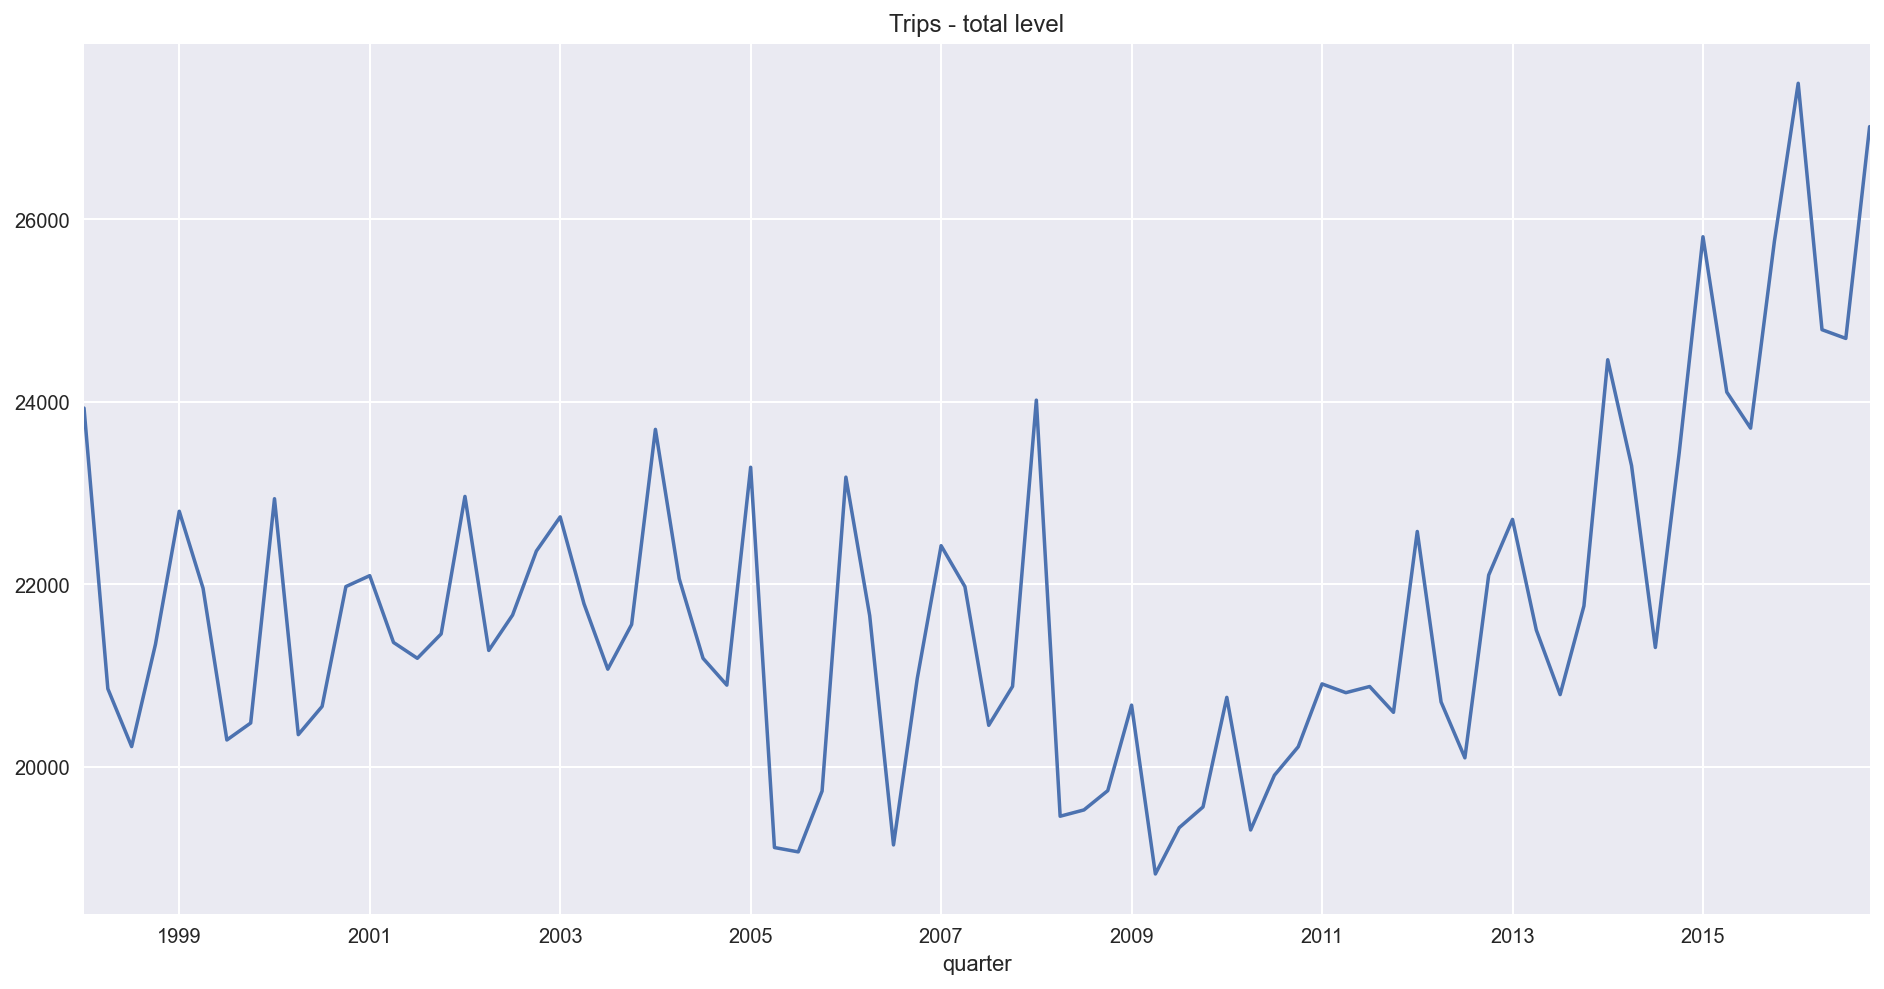

In [8]:
hierarchy_df["total"].plot(title="Trips - total level");

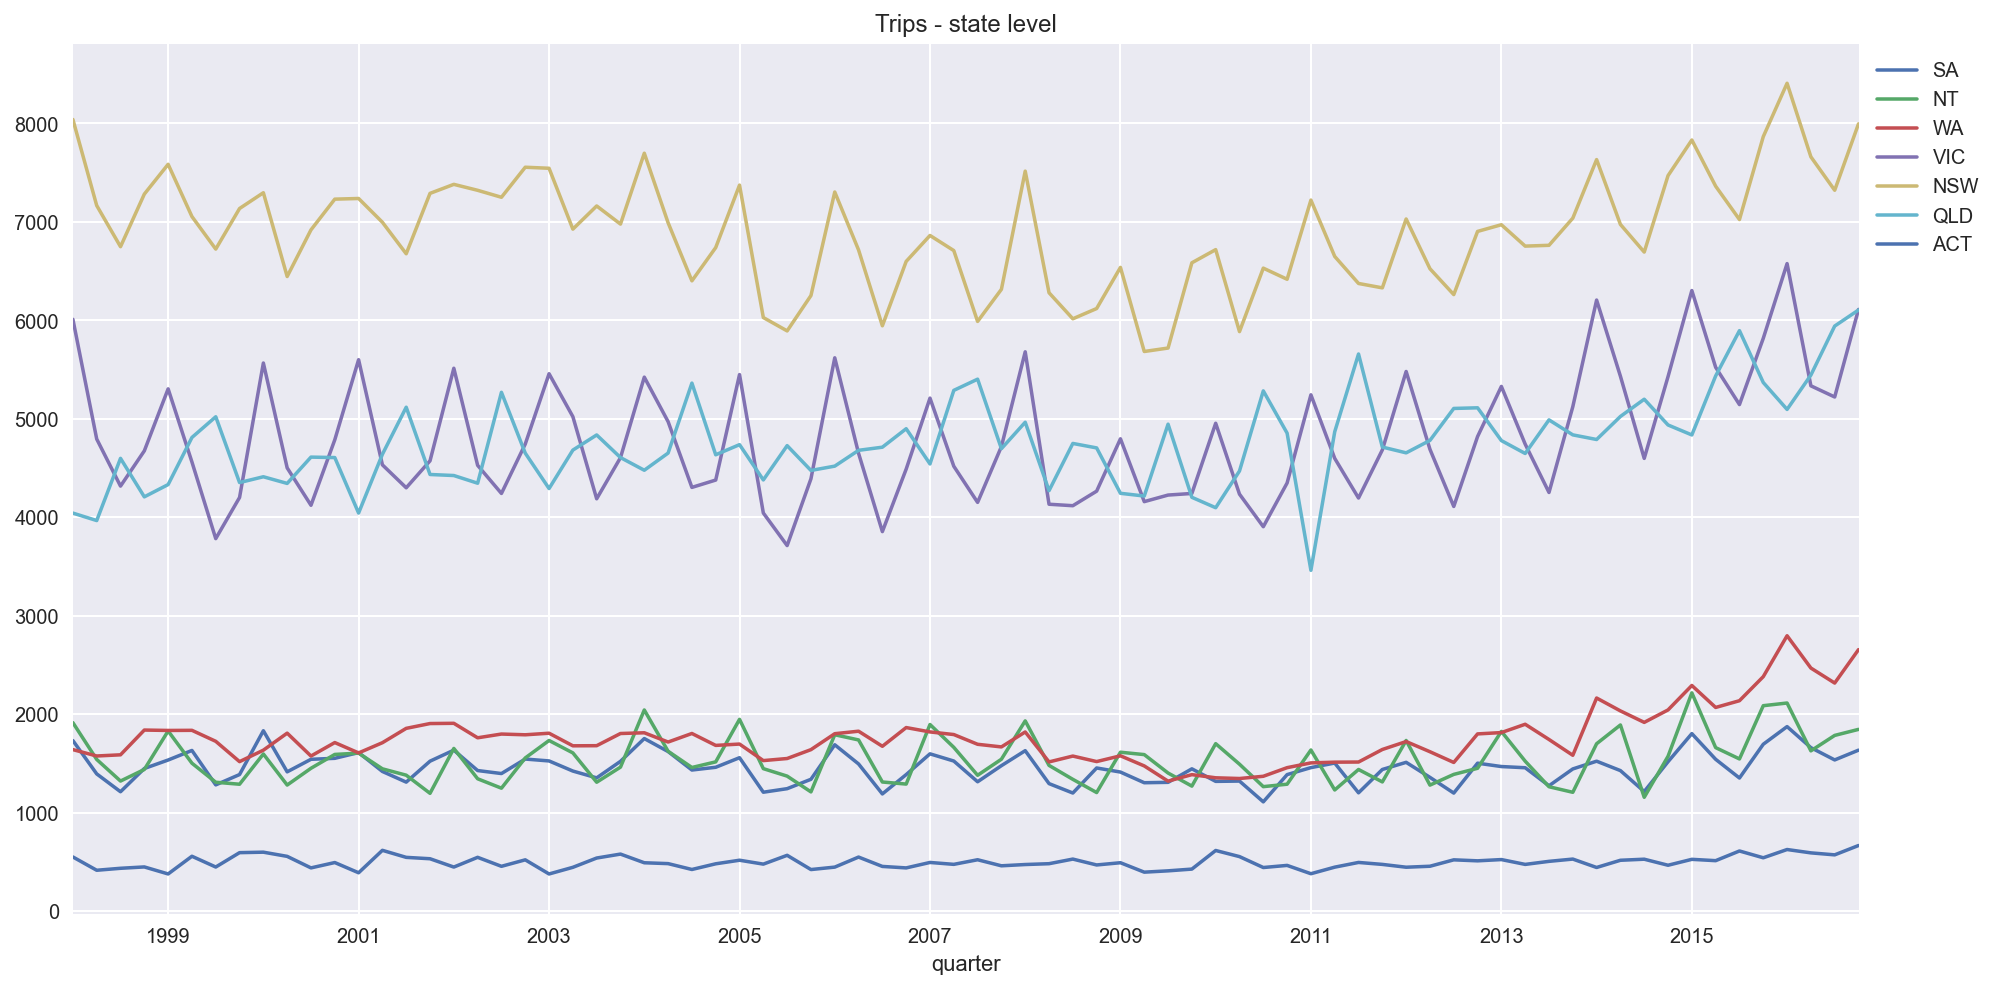

In [9]:
ax = hierarchy_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

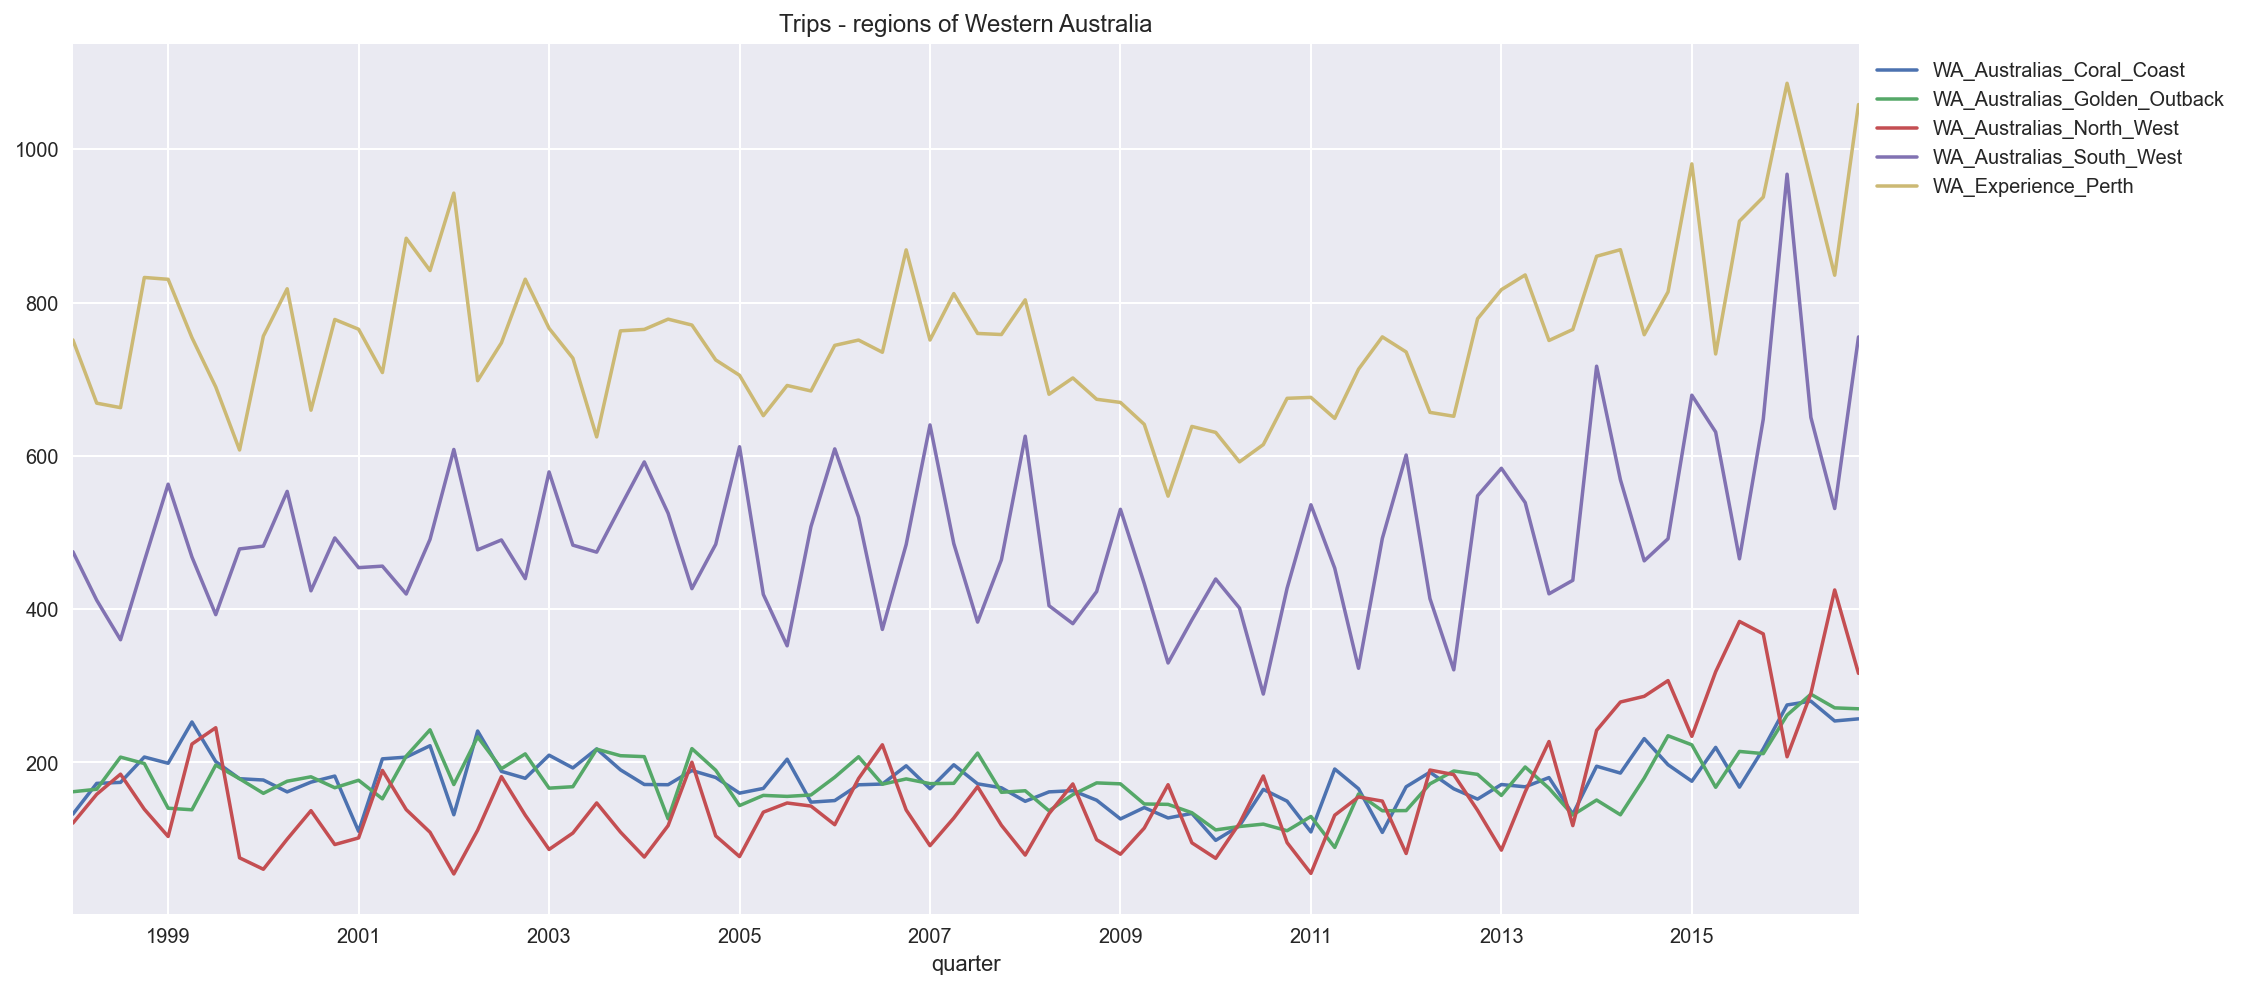

In [10]:
ax = hierarchy_df[hierarchy['WA']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## Hierarchical time series forecasting

In [11]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips");
    

### The bottom-up approach

In [16]:
model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 308.02it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x160a16fa0>


KeyError: 8

In [17]:
model_bu_prophet = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
model_bu_prophet = model_bu_prophet.fit(hierarchy_df, hierarchy)
pred_bu_prophet = model_bu_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:00<01:17,  1.09it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:01<01:13,  1.13it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:02<01:14,  1.10it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

KeyError: 8

### The top-down approach

In [18]:
model_td_arima = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
model_td_arima = model_td_arima.fit(hierarchy_df, hierarchy)
pred_td_arima = model_td_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 320.43it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x16337e8b0>


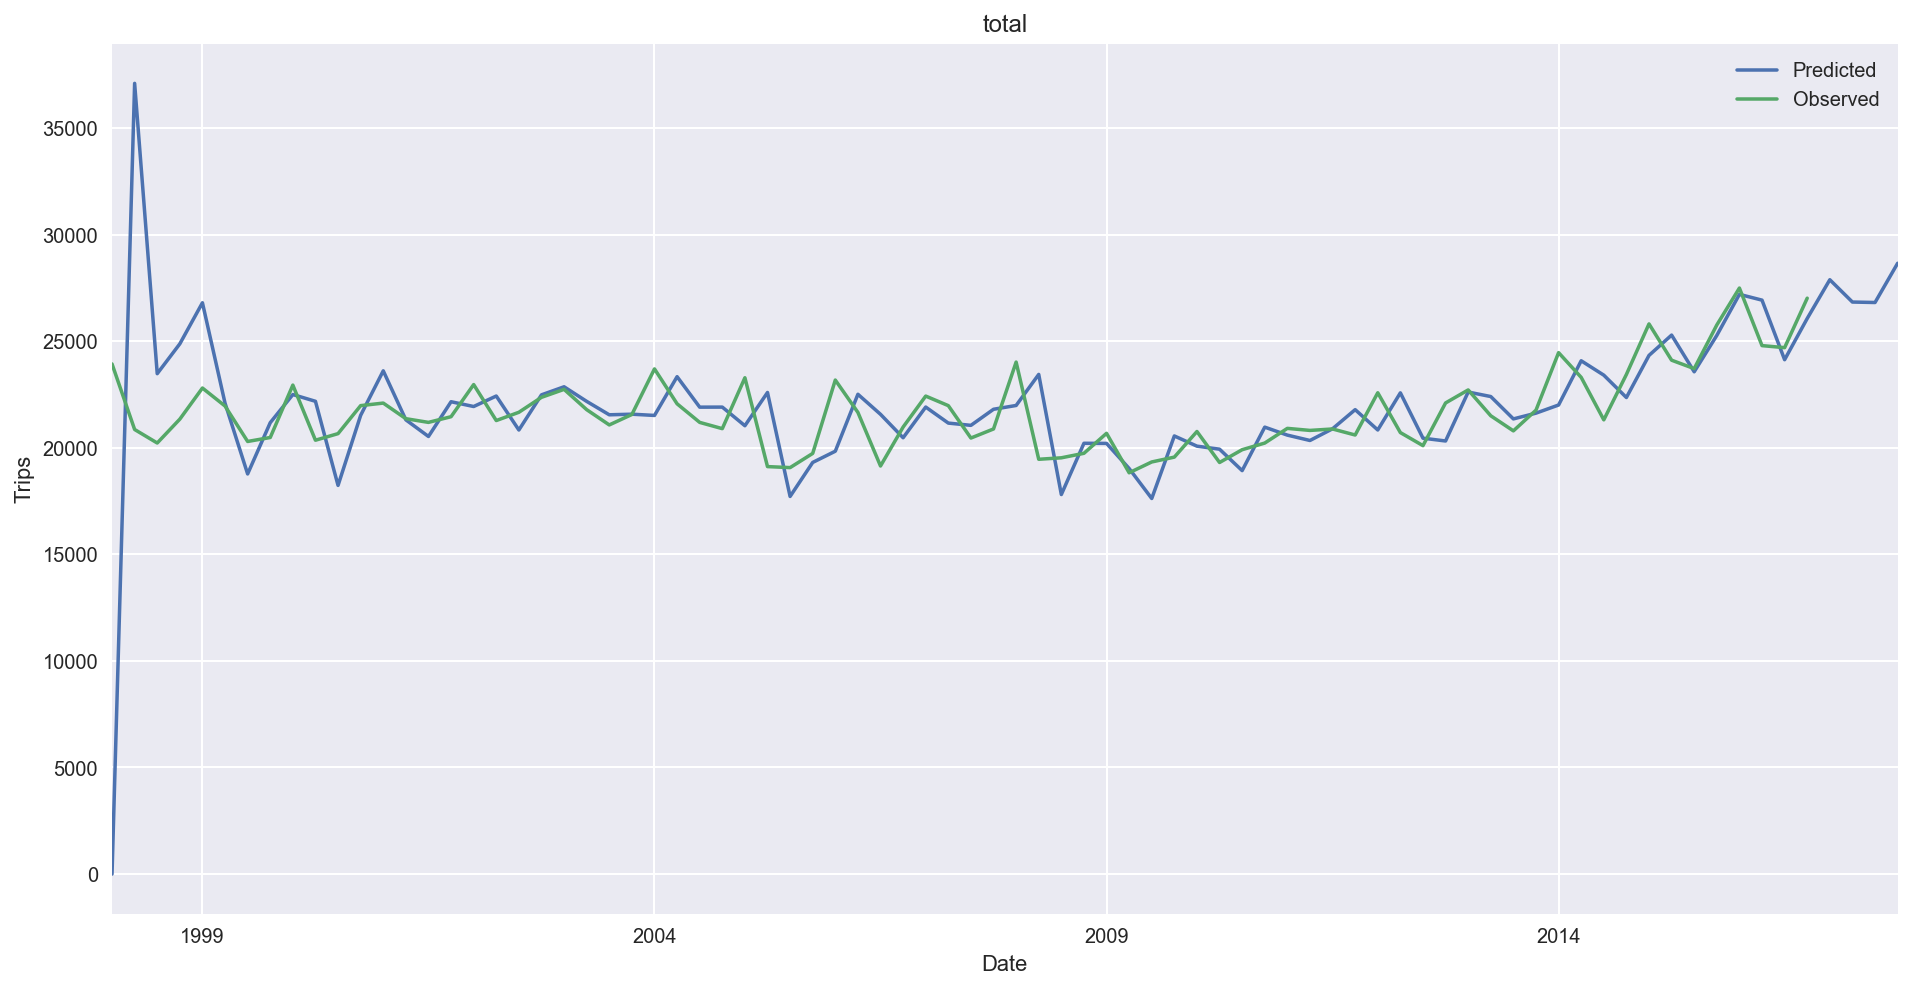

In [49]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['total'])

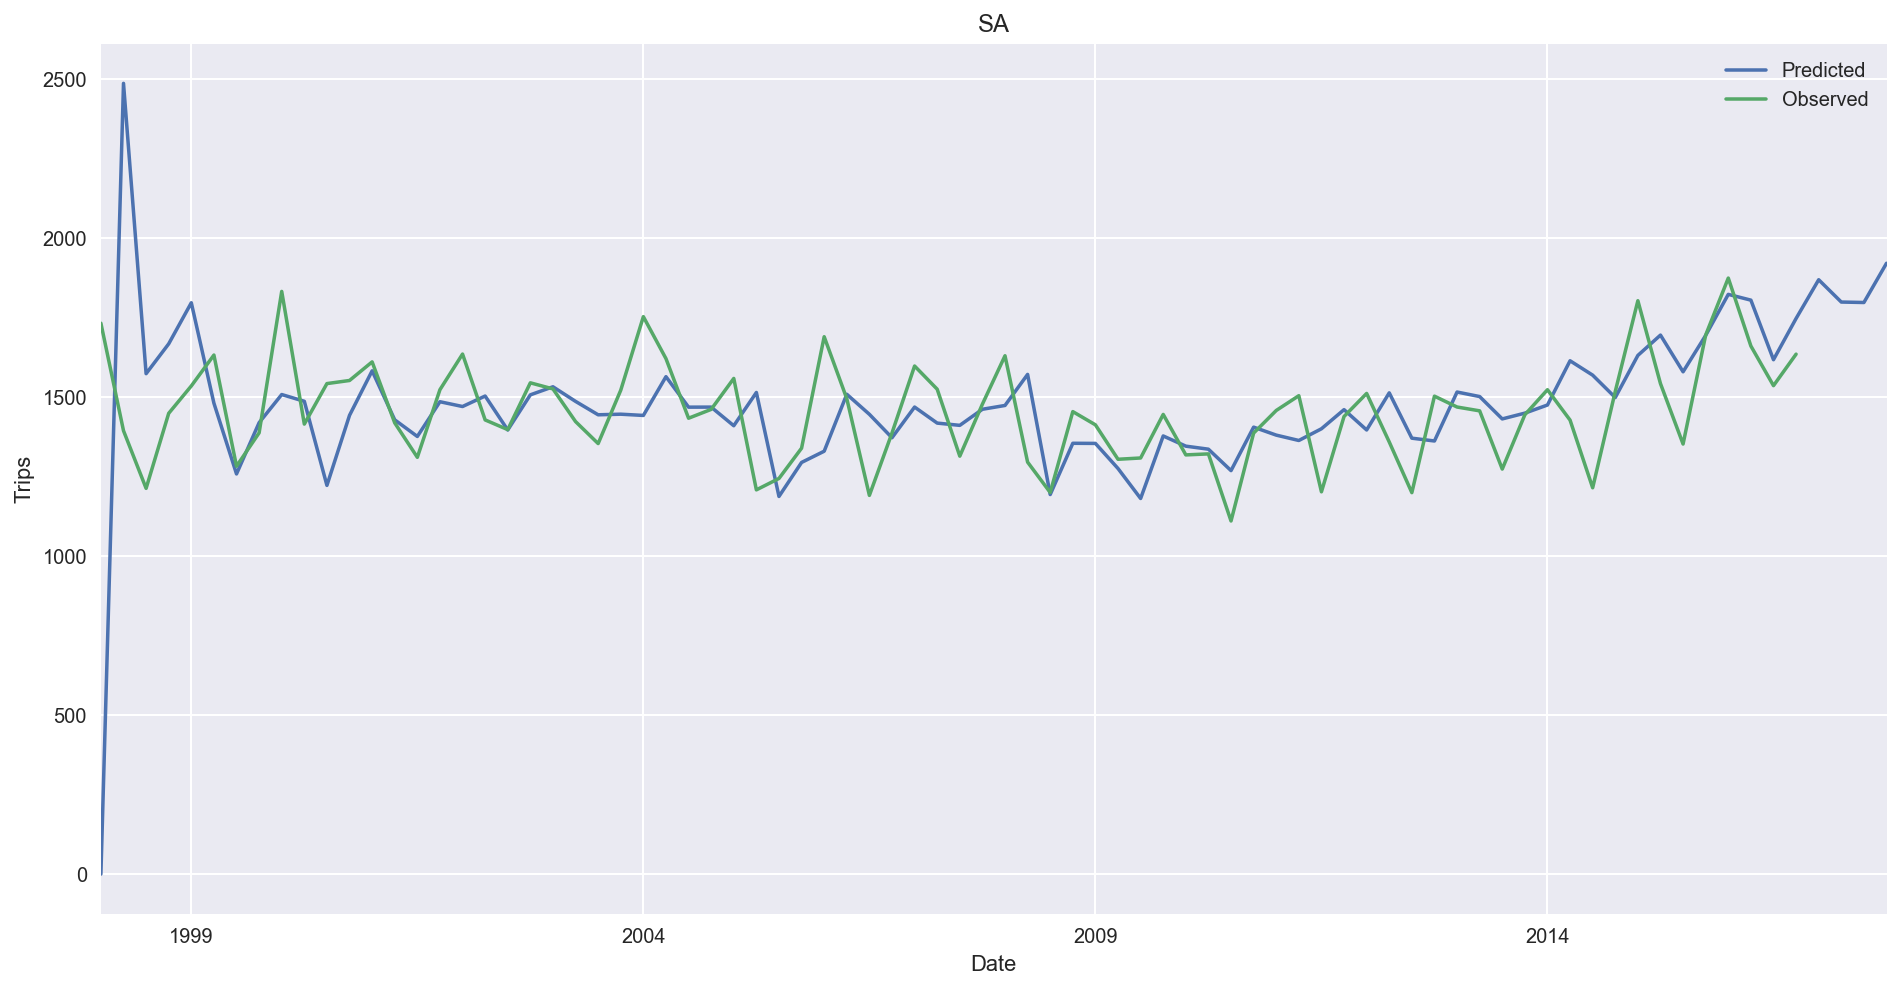

In [45]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['SA'])

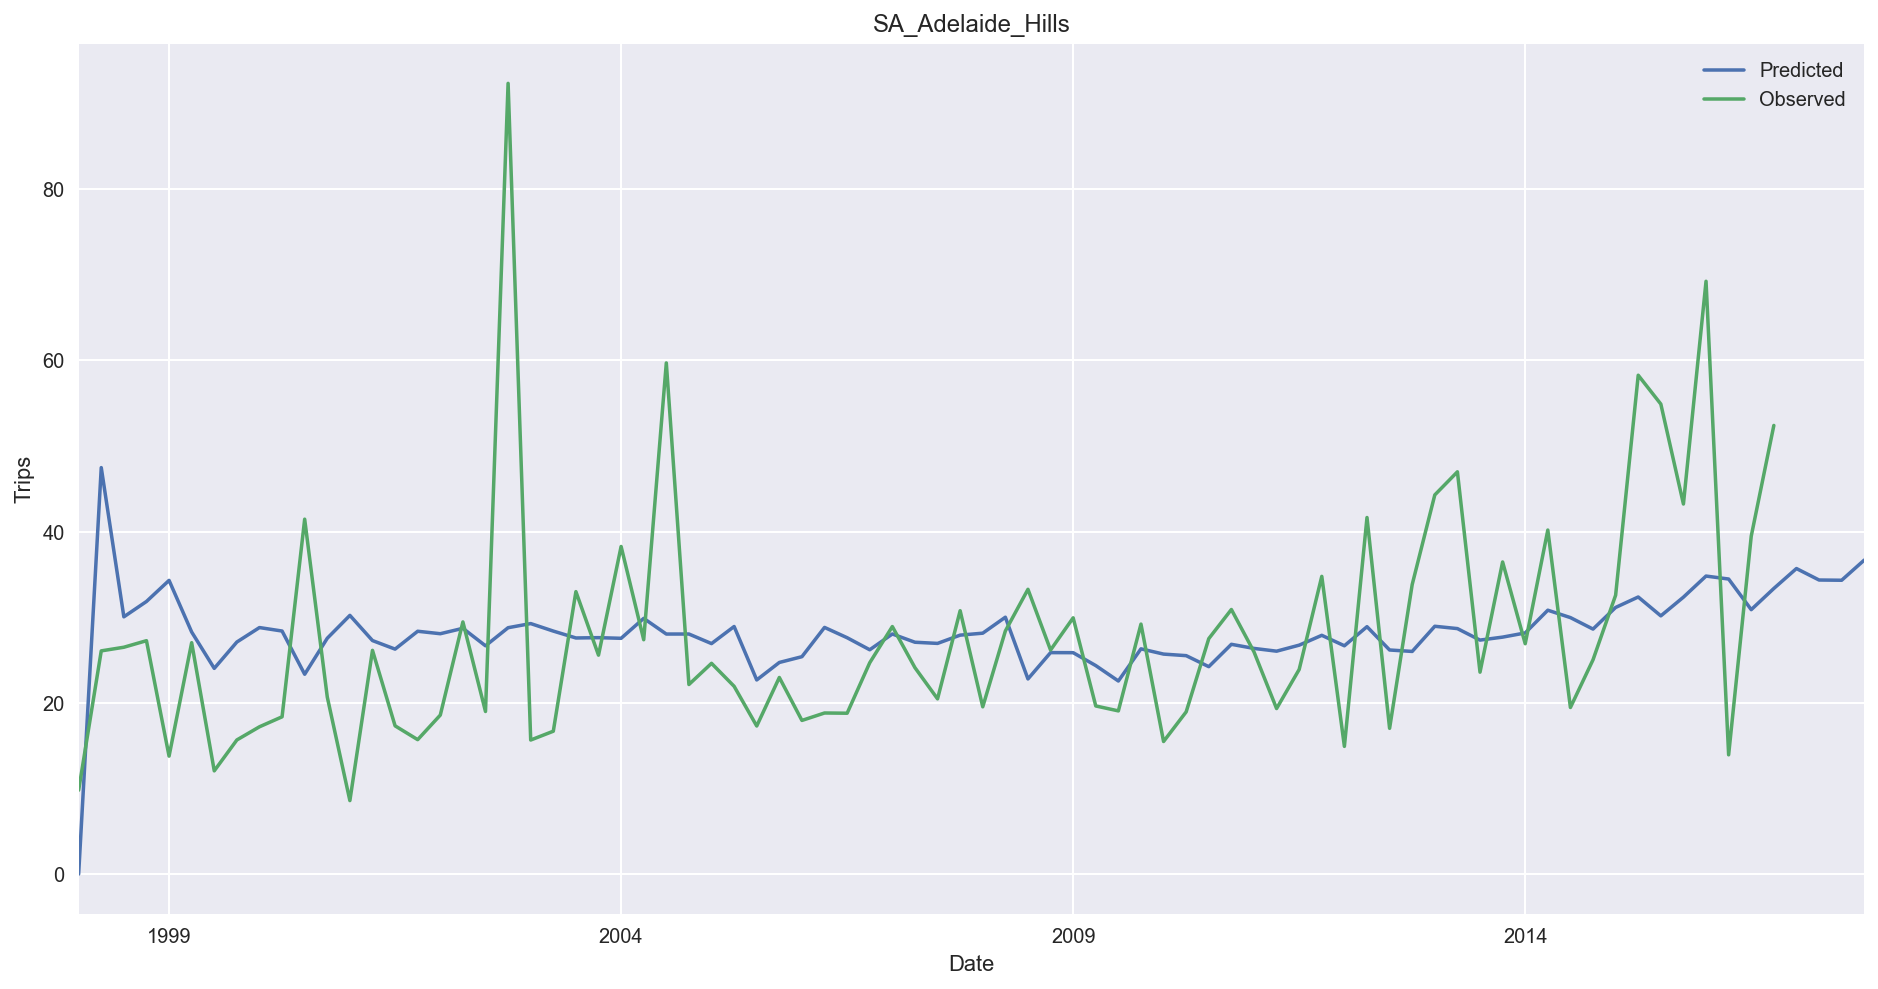

In [50]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['SA_Adelaide_Hills'])

In [19]:
model_td_prophet = hts.HTSRegressor(model='prophet', revision_method='AHP', n_jobs=0)
model_td_prophet = model_td_prophet.fit(hierarchy_df, hierarchy)
pred_td_prophet = model_td_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:00<01:20,  1.04it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:01<01:17,  1.07it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:02<01:20,  1.02it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

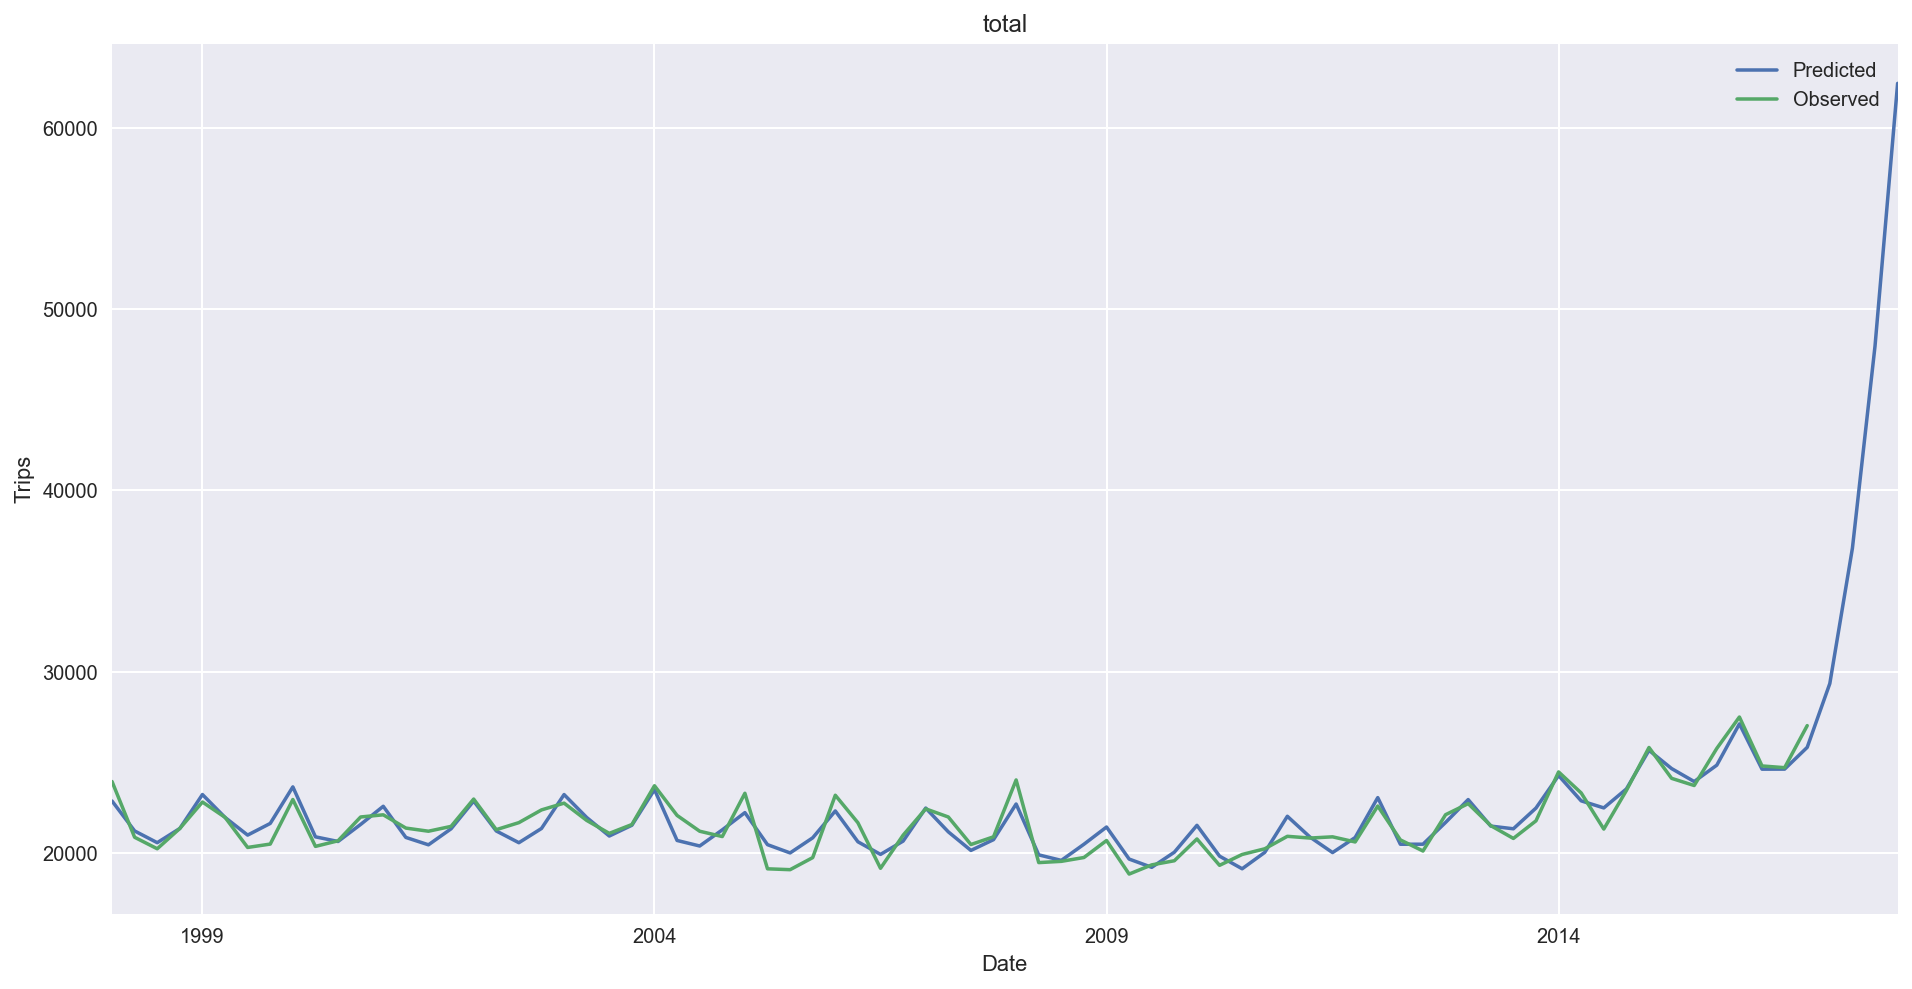

In [27]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['total'])

### Reconciliation - optimal combination using OLS

In [20]:
model_ols_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model_ols_arima = model_ols_arima.fit(hierarchy_df, hierarchy)
pred_ols_arima = model_ols_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 324.24it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x16289d340>


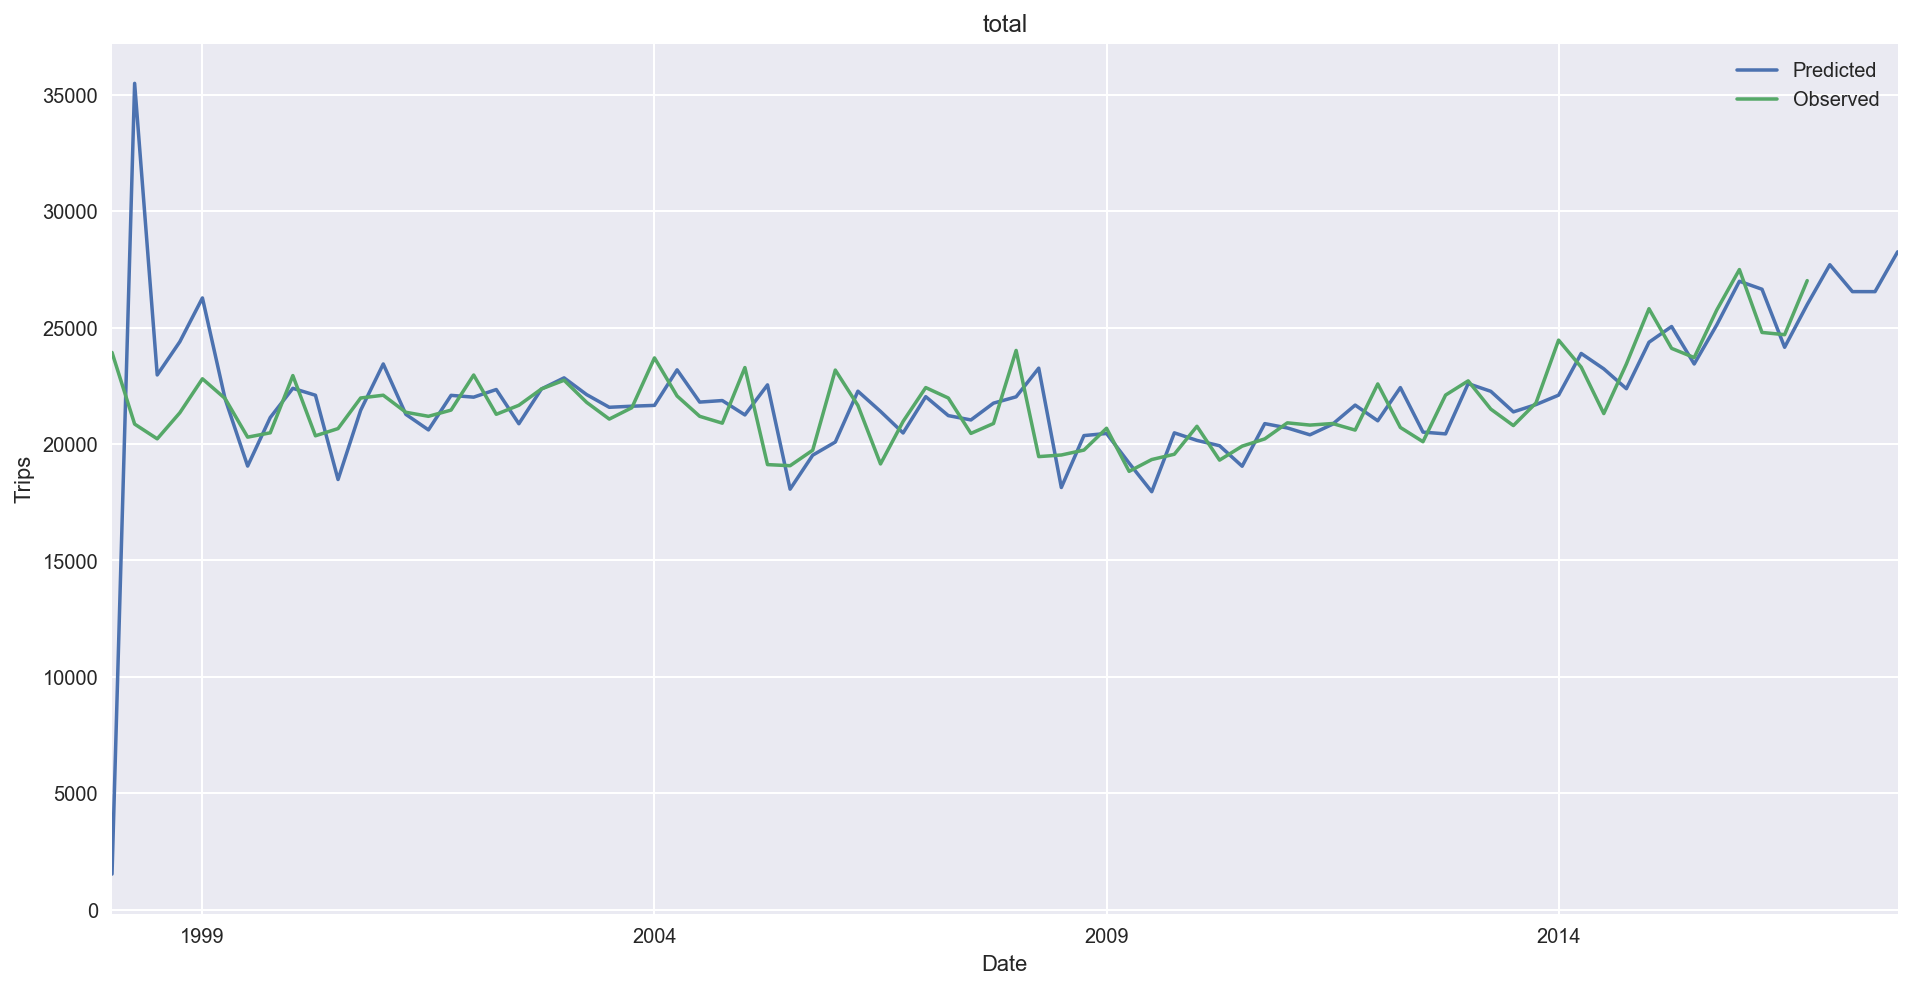

In [46]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['total'])

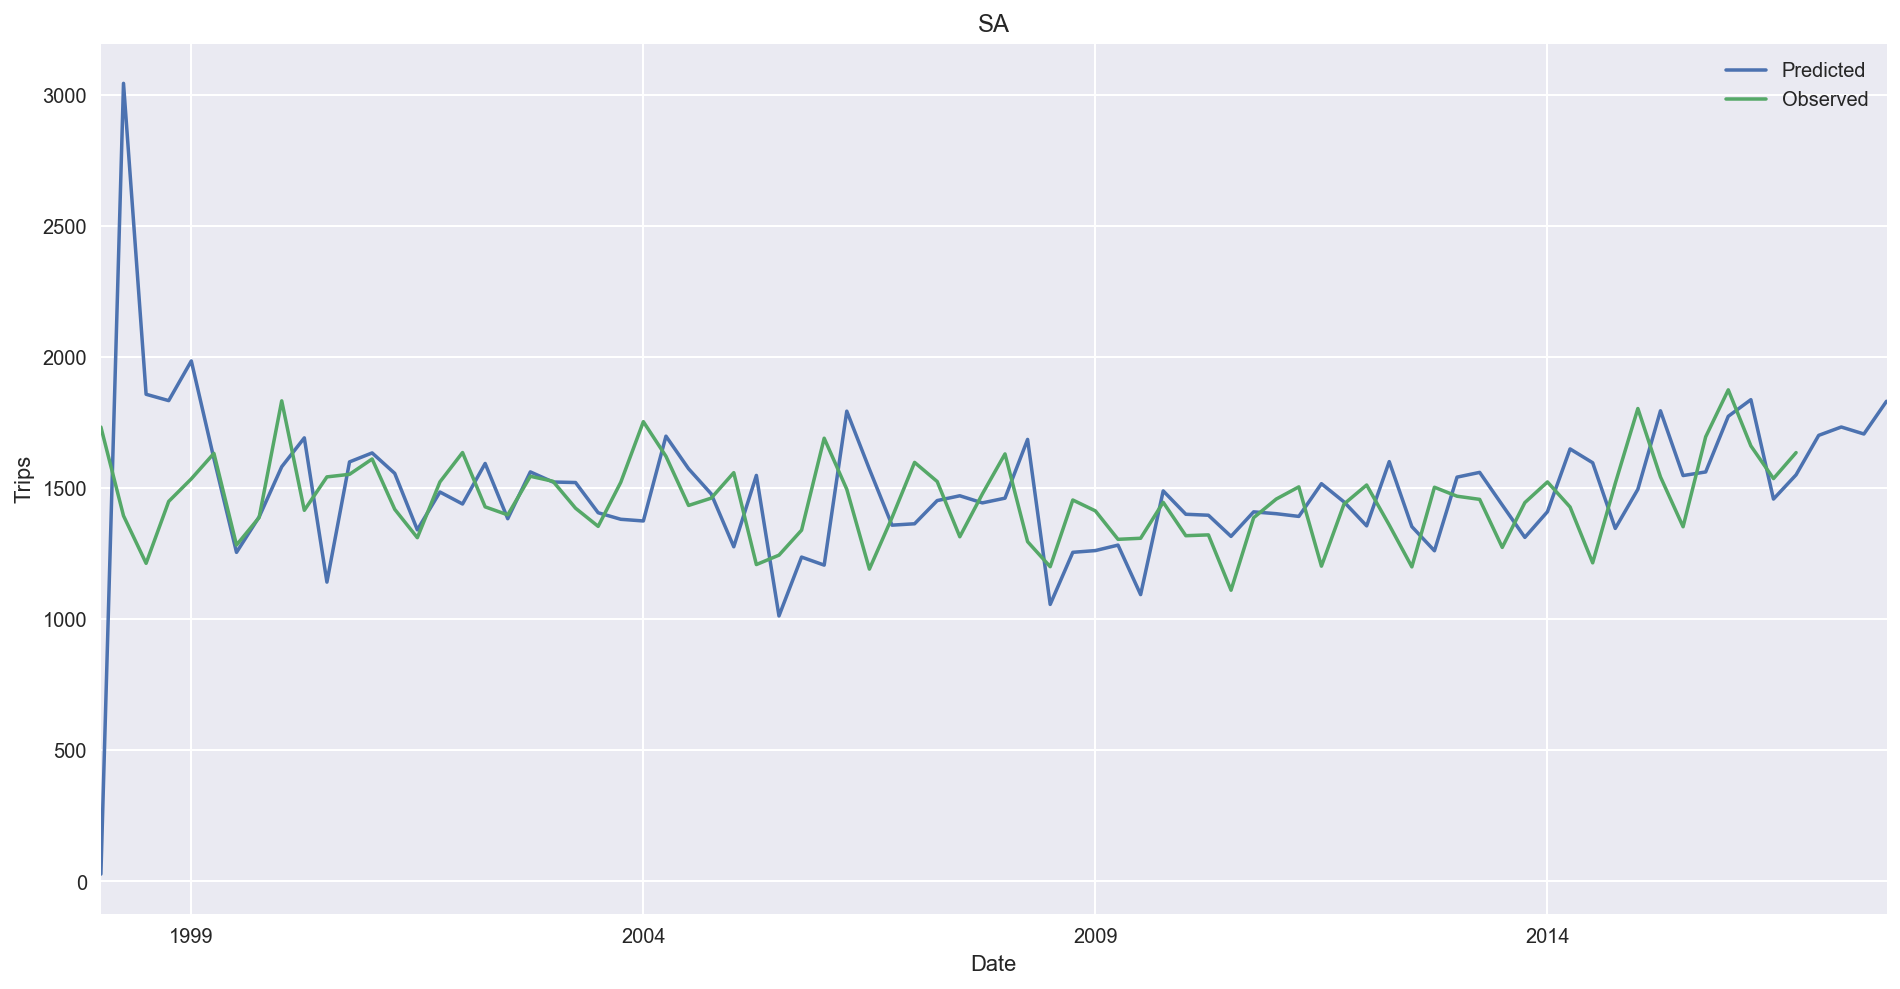

In [47]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['SA'])

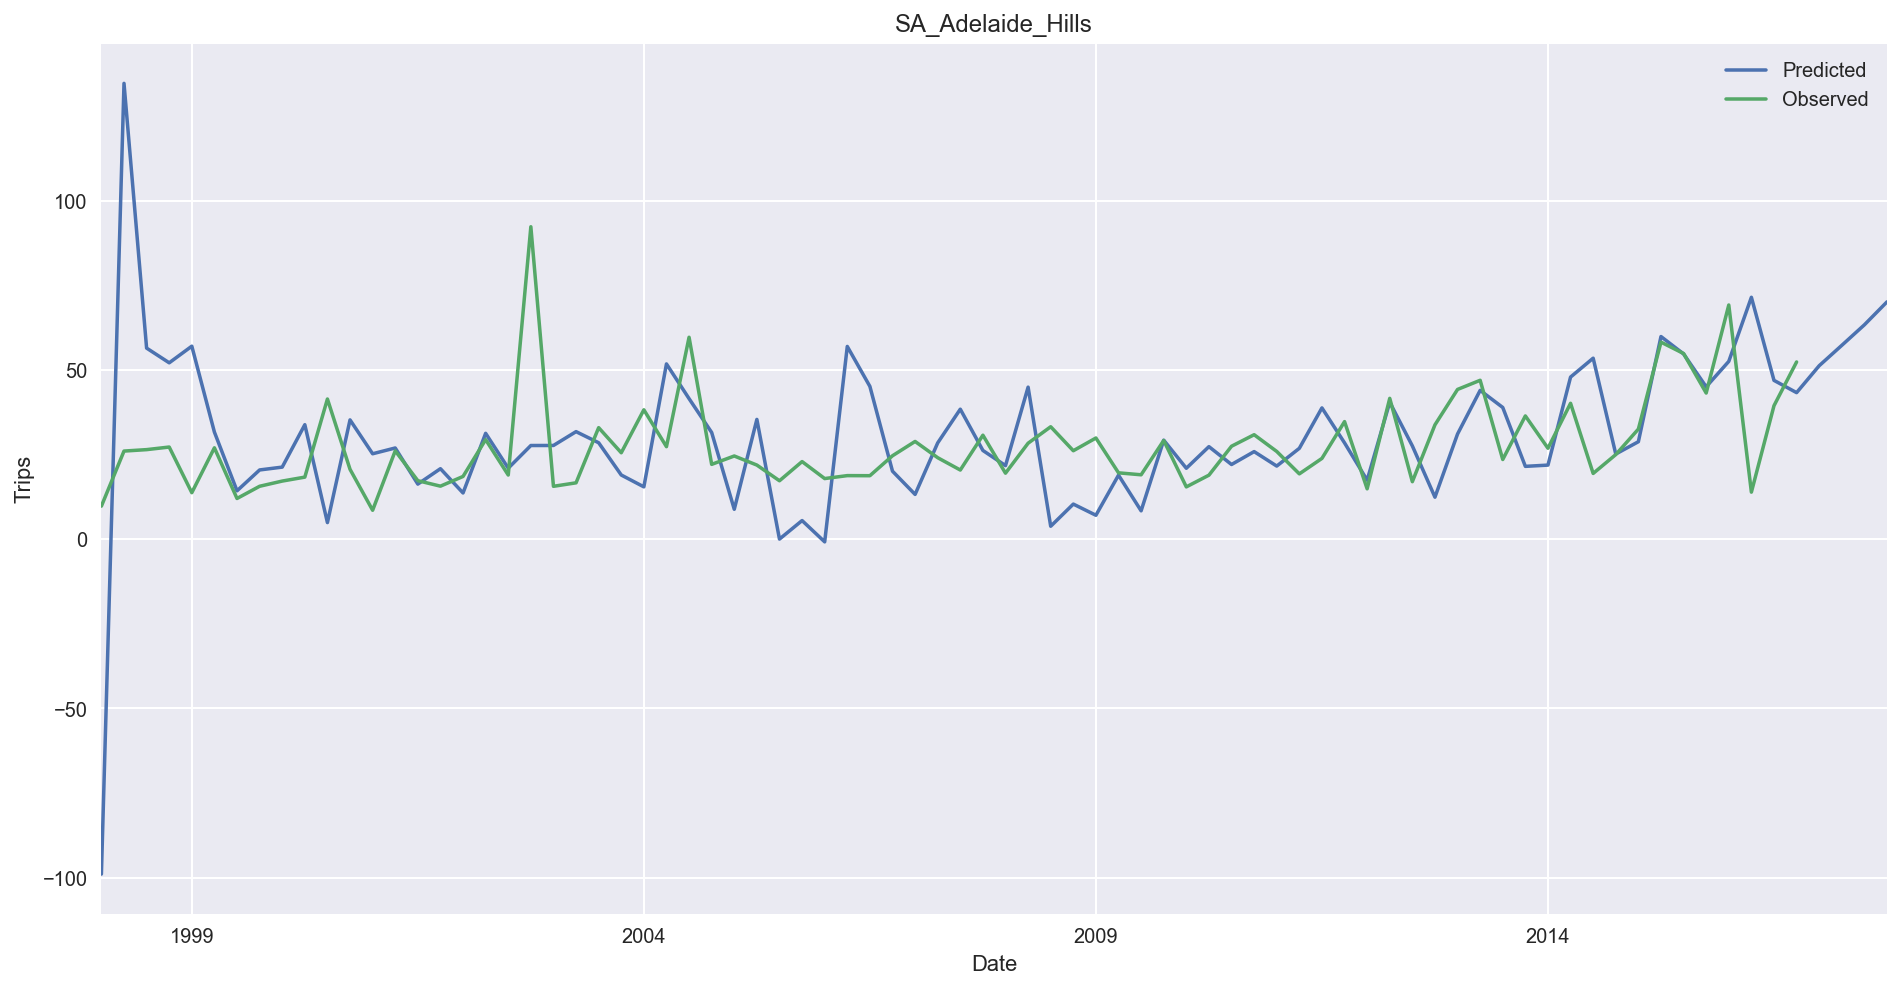

In [48]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['SA_Adelaide_Hills'])

In [22]:
model_ols_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model_ols_prophet = model_ols_prophet.fit(hierarchy_df, hierarchy)
pred_ols_prophet = model_ols_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:00<01:22,  1.02it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:01<01:18,  1.06it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:02<01:19,  1.03it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

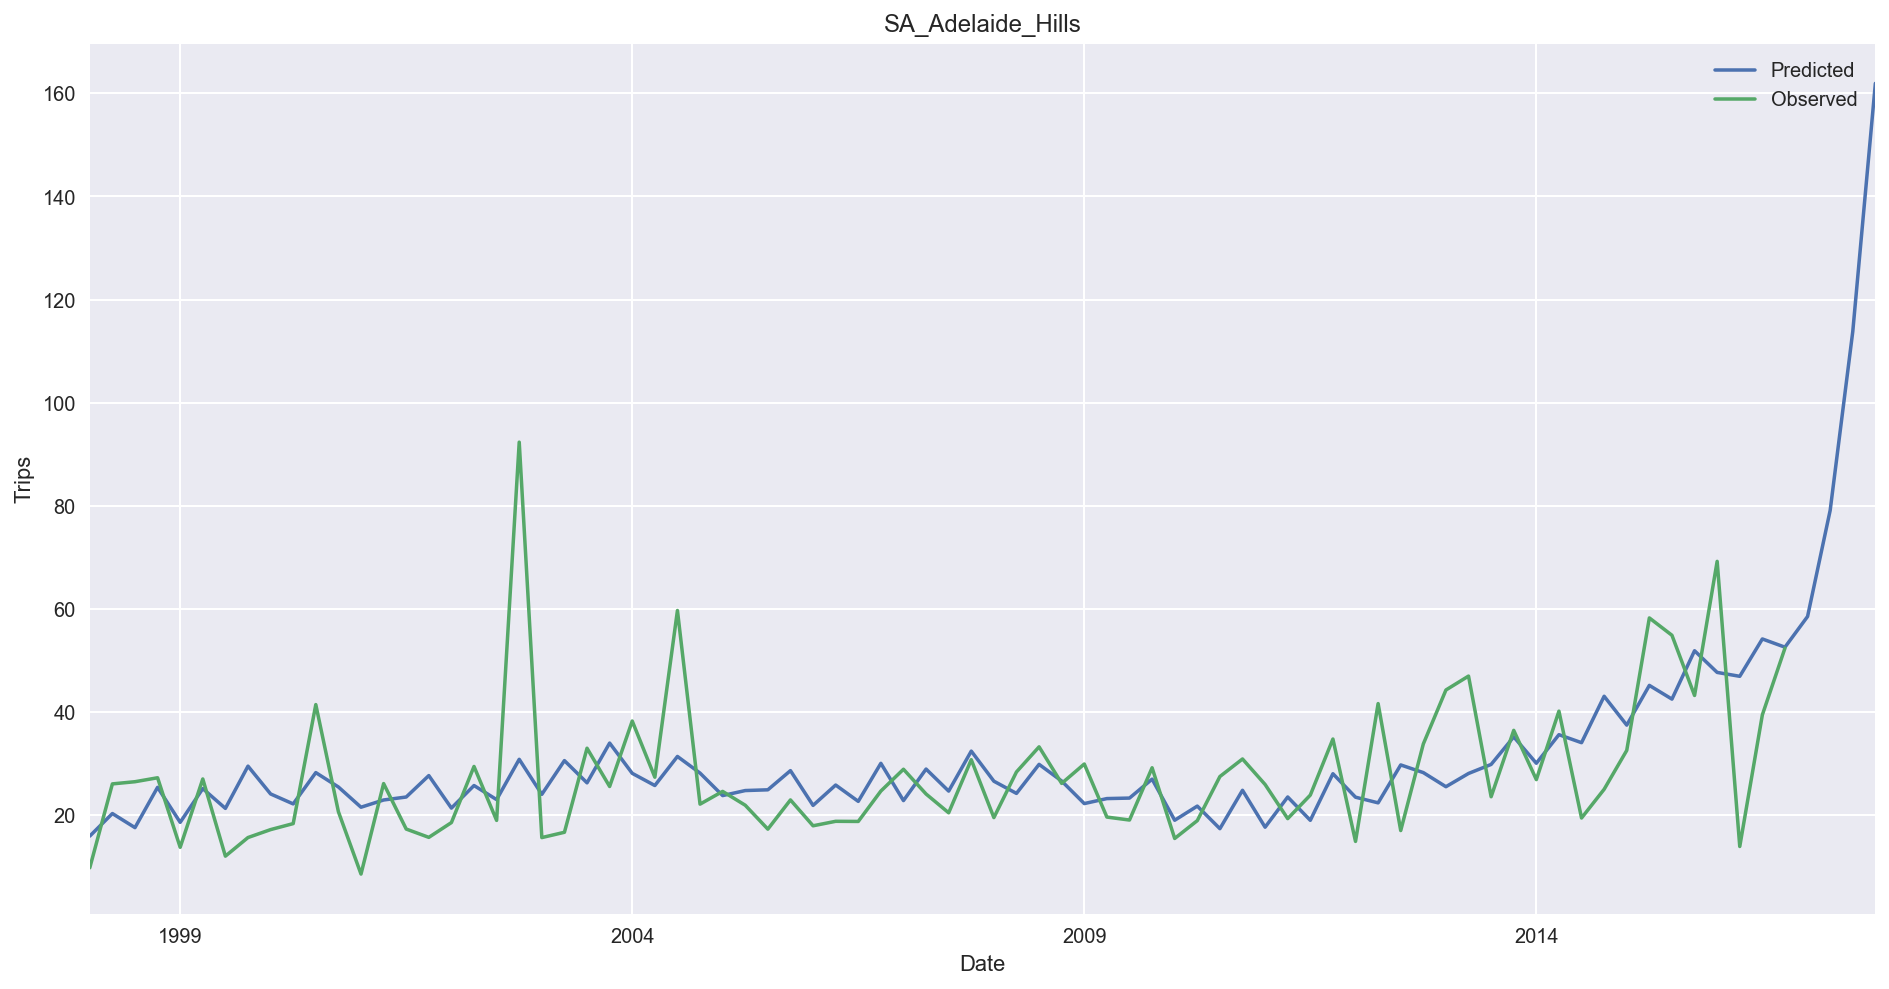

In [42]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['total'])